In [1]:
using LaplaceRedux.Data
using Flux

using CSV
using DataFrames

using Random
Random.seed!(42)

df = CSV.read("data1.csv", DataFrame)
x = Matrix(df[:, 1:2])
x = [x[i, :] for i in 1:size(x, 1)]
y = df[:, 3]

X = hcat(x...)
y_train = Flux.onehotbatch(y, unique(y))
y_train = Flux.unstack(y_train',1)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.1.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA C:\Users\Lenovo\.julia\packages\CUDA\s0e3j\src\initialization.jl:70


100-element Vector{Vector{Bool}}:
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 ⋮
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]

In [2]:
data = zip(x,y_train)
n_hidden = 3
D = size(X,1)
out_dim = length(unique(y))
nn = Chain(
    Dense(D, n_hidden, σ),
    Dense(n_hidden, out_dim)
)  
loss(x, y) = Flux.Losses.logitcrossentropy(nn(x), y)

loss (generic function with 1 method)

In [3]:
using Flux.Optimise: update!, Adam
using Statistics
opt = Adam()
epochs = 100
avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))
show_every = epochs/10

for epoch = 1:epochs
    for d in data
        gs = gradient(Flux.params(nn)) do
            l = loss(d...)
        end
        update!(opt, Flux.params(nn), gs)
    end
    if epoch % show_every == 0
        println("Epoch " * string(epoch))
        @show avg_loss(data)
    end
end

Epoch 10

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 3, σ)    # 9 parameters
│   summary(x) = "2-element Vector{Float64}"
└ @ Flux C:\Users\Lenovo\.julia\packages\Flux\FWgS0\src\layers\stateless.jl:50



avg_loss(data) = 1.080402f0
Epoch 20
avg_loss(data) = 0.8426136f0
Epoch 30
avg_loss(data) = 0.5942515f0
Epoch 40
avg_loss(data) = 0.42556396f0
Epoch 50
avg_loss(data) = 0.30842268f0
Epoch 60
avg_loss(data) = 0.22512102f0
Epoch 70
avg_loss(data) = 0.16523513f0
Epoch 80
avg_loss(data) = 0.121795416f0
Epoch 90
avg_loss(data) = 0.090053044f0
Epoch 100
avg_loss(data) = 0.06675235f0


In [4]:
using LaplaceRedux
la = Laplace(nn; likelihood=:classification)
fit!(la, data)
optimize_prior!(la; verbose=true, n_steps=1000)

[ Info: Iteration 100: P₀=0.04045028654498701, σ=1.0


loss(exp.(logP₀), exp.(logσ)) = 14.32938574981732
Log likelihood: -6.675234727561474
Log det ratio: 10.168093556632613
Scatter: 5.140208487879078
loss(exp.(logP₀), exp.(logσ)) = 14.304358354703037
Log likelihood: -6.675234727561474
Log det ratio: 10.739516572845744
Scatter: 4.518730681437382
loss(exp.(logP₀), exp.(logσ)) = 14.304334115171482
Log likelihood: -6.675234727561474
Log det ratio: 10.758504413187396
Scatter: 4.499694362032621
loss(exp.(logP₀), exp.(logσ)) = 14.304334115137006
Log likelihood: -6.675234727561474
Log det ratio: 10.75848150538647
Scatter: 4.499717269764597


[ Info: Iteration 200: P₀=0.03555963757399765, σ=1.0
[ Info: Iteration 300: P₀=0.03540983342179249, σ=1.0
[ Info: Iteration 400: P₀=0.03541001369158596, σ=1.0


loss(exp.(logP₀), exp.(logσ)) = 14.304334115137024
Log likelihood: -6.675234727561474
Log det ratio: 10.758481777755762
Scatter: 4.499716997395337
loss(exp.(logP₀), exp.(logσ)) = 14.304334115137015
Log likelihood: -6.675234727561474
Log det ratio: 10.758481775287478
Scatter: 4.499716999863604
loss(exp.(logP₀), exp.(logσ)) = 14.304334115137024
Log likelihood: -6.675234727561474
Log det ratio: 10.758481775282434
Scatter: 4.499716999868666


[ Info: Iteration 500: P₀=0.03541001154820704, σ=1.0
[ Info: Iteration 600: P₀=0.03541001156763077, σ=1.0
[ Info: Iteration 700: P₀=0.03541001156767062, σ=1.0
[ Info: Iteration 800: P₀=0.03541001156767032, σ=1.0


loss(exp.(logP₀), exp.(logσ)) = 14.30433411513704
Log likelihood: -6.675234727561474
Log det ratio: 10.758481775282505
Scatter: 4.499716999868629
loss(exp.(logP₀), exp.(logσ)) = 14.30433411513704
Log likelihood: -6.675234727561474
Log det ratio: 10.758481775282505
Scatter: 4.499716999868629
loss(exp.(logP₀), exp.(logσ)) = 14.30433411513704
Log likelihood: -6.675234727561474
Log det ratio: 10.758481775282505
Scatter: 4.499716999868629


[ Info: Iteration 900: P₀=0.03541001156767032, σ=1.0
[ Info: Iteration 1000: P₀=0.03541001156767032, σ=1.0


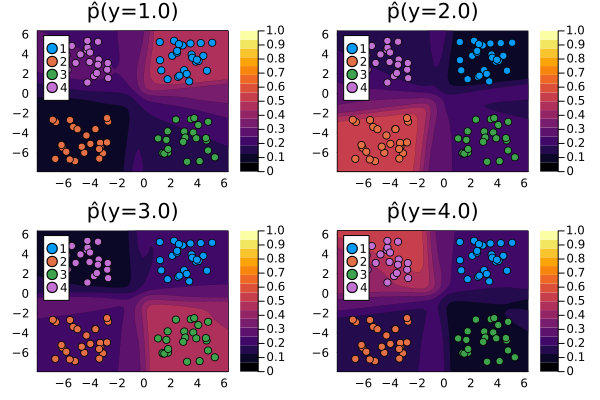

In [5]:
using Plots
_labels = sort(unique(y))
plt_list = []
for target in _labels
    plt = plot(la, X, y; target=target, clim=(0,1))
    push!(plt_list, plt)
end
plot(plt_list...)

In [6]:
predictions_probit = reduce(hcat, predict(la, X))
predictions_probit = reshape(predictions_probit, 4, 100)

[35.03737308198131 35.07506907700313 35.09420493726273 35.98625350117493 35.06226421824947 35.07770108199286 39.08535170145788 35.09198902076396 38.180492109439804 35.054677016714635 35.0686775888191 35.144110816360886 35.05941630534085 35.07028899209495 35.16441931789449 35.08847709285553 35.11276200850622 43.46825412968718 35.142687205095044 36.69015501266843 35.38483056198146 37.65743900687204 35.27036465319421 35.12951958672609 40.04466859245465 46.31069839500102 46.17665497214734 46.14996167826542 46.27997866119988 46.25460377995897 46.190173589821626 46.27826245786899 46.26989282629013 46.072286702139635 46.25273588148248 46.58460392756763 46.267876021409535 46.13352408802032 46.286130607331295 46.286113277171566 46.23633485329062 46.26094728944983 46.071433107555364 46.15115491999734 46.282602163441496 46.22539274430224 46.277791638813014 46.219312879697 46.277171262656324 46.28721013053381 151.12444262387012 69.48410262472957 61.886691701912554 178.3395040696252 78.030941694581

4×100 Matrix{Float64}:
 0.486246   0.486436   0.485236   0.482088  …  0.280883   0.25366   0.24928
 0.0985743  0.0985119  0.0989323  0.100164     0.163949   0.153605  0.142585
 0.191665   0.191705   0.191972   0.193267     0.0957875  0.095997  0.0925687
 0.223515   0.223347   0.22386    0.224482     0.459381   0.496738  0.515566

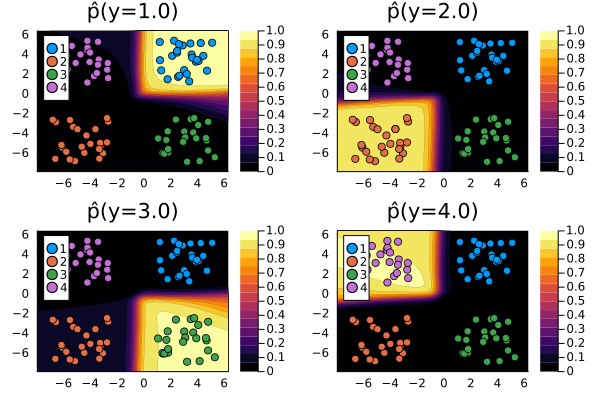

In [7]:
_labels = sort(unique(y))
plt_list = []
for target in _labels
    plt = plot(la, X, y; target=target, clim=(0,1), link_approx=:plugin)
    push!(plt_list, plt)
end
plot(plt_list...)

In [8]:
predictions_plugin = reduce(hcat, predict(la, X, link_approx=:plugin))
predictions_plugin = reshape(predictions_plugin, 4, 100)

[35.03737308198131 35.07506907700313 35.09420493726273 35.98625350117493 35.06226421824947 35.07770108199286 39.08535170145788 35.09198902076396 38.180492109439804 35.054677016714635 35.0686775888191 35.144110816360886 35.05941630534085 35.07028899209495 35.16441931789449 35.08847709285553 35.11276200850622 43.46825412968718 35.142687205095044 36.69015501266843 35.38483056198146 37.65743900687204 35.27036465319421 35.12951958672609 40.04466859245465 46.31069839500102 46.17665497214734 46.14996167826542 46.27997866119988 46.25460377995897 46.190173589821626 46.27826245786899 46.26989282629013 46.072286702139635 46.25273588148248 46.58460392756763 46.267876021409535 46.13352408802032 46.286130607331295 46.286113277171566 46.23633485329062 46.26094728944983 46.071433107555364 46.15115491999734 46.282602163441496 46.22539274430224 46.277791638813014 46.219312879697 46.277171262656324 46.28721013053381 151.12444262387012 69.48410262472957 61.886691701912554 178.3395040696252 78.030941694581

4×100 Matrix{Float32}:
 0.953281     0.953475     0.952804     …  0.0457436    0.0545936
 0.000381995  0.000379759  0.000389999     0.00733526   0.0052857
 0.0132044    0.0131913    0.0133976       0.000861187  0.000701007
 0.0331323    0.032954     0.0334083       0.94606      0.93942